In [ ]:
"""
    Takes too long to run on a single video. Plus barely extracts any features.
    Pick specific videos that have good frontal views, and extract symbols from
    ~ 5000 frames per video.
"""

import sys
ROOT_DIR = ""
SORT_DIR = ""
sys.path.append(ROOT_DIR) # Adding MRCNN root dir to path to import models
sys.path.append(SORT_DIR) # Adding sort to path to import it

from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgba2rgb
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import mediapipe as mp
from mrcnn import config # Importing RCNN
from mrcnn import utils
import mrcnn.model as modellib
import sort # Importing SORT

class InferenceConfig(config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME = 'coco'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

def get_average(landmarks):
    """
    Function calculates the average position of a list of landmarks

    Parameters
        - landmarks (list): List of landmarks
    Return
        A tuple with the average x and y coordinates for a given list of
        landmarks
    """
    avg_x = 0
    avg_y = 0
    for landmark in landmarks:
        avg_x += landmark.x
        avg_y += landmark.y
    return avg_x/len(landmarks), avg_y/len(landmarks)

def get_landmark_values(landmark_enums, results):
    """
    Returns x, y coordinates of the landmark values corresponding to the
    landmark_enums

    Parameters
        - landmark_enums (list): A list of enums for the landmarks
        - results : the return value from mediapipe's mp_pose.Pose.process()
    Returns
        The x, y coordinates of the average position of the landmarks passed
    """
    values = []
    for enum in landmark_enums:
        values.append(results.pose_landmarks.landmark[enum])
    return get_average(values)

# Initializing some global variables
VIDEO_FOLDER = "C:\\Users\\s4582742\\Downloads\\videos"
OUTPUT_FOLDER = "./output2"
VIS = False#"--vis" in sys.argv
OUTPUT = True#"--output" in sys.argv
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Read videos
video_paths = [file for file in os.listdir(VIDEO_FOLDER)
                if file.endswith(".mp4") or file.endswith(".mkv")]
num_vids = len(video_paths)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
# Getting Enums for the landmarks we are interested in
hand_landmarks_left = [mp_pose.PoseLandmark.LEFT_PINKY,
                       mp_pose.PoseLandmark.LEFT_INDEX,
                       mp_pose.PoseLandmark.LEFT_THUMB]

hand_landmarks_right = [mp_pose.PoseLandmark.RIGHT_PINKY,
                        mp_pose.PoseLandmark.RIGHT_INDEX,
                        mp_pose.PoseLandmark.RIGHT_THUMB]

mouth_landmarks = [mp_pose.PoseLandmark.MOUTH_LEFT,
                   mp_pose.PoseLandmark.MOUTH_RIGHT]

eye_landmarks = [mp_pose.PoseLandmark.LEFT_EYE,
                 mp_pose.PoseLandmark.RIGHT_EYE]

shoulder_landmarks = [mp_pose.PoseLandmark.LEFT_SHOULDER,
                      mp_pose.PoseLandmark.RIGHT_SHOULDER]

hip_landmarks = [mp_pose.PoseLandmark.LEFT_HIP,
                 mp_pose.PoseLandmark.RIGHT_HIP]

conf = InferenceConfig()
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference",
                          model_dir=MODEL_DIR,
                          config=conf)
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)
pose = mp_pose.Pose(min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

symbols = {"A":(), "B":(), "C":(), "D":(), "E":(), "F":(), "G":()}
if VIS:
    colors = {"A":(225, 0, 0),
              "B":(0, 225, 0),
              "C":(0, 0, 225),
              "D":(225, 225, 0),
              "E":(0, 225, 225),
              "F":(225, 0, 225),
              "G":(225, 225, 225)}

check = lambda limits, pos: (pos < limits[0]) and (pos > limits[1])

In [ ]:
if OUTPUT:
    print("Starting Symbolization Process")
for i, video_path in enumerate(video_paths):
    if OUTPUT:
        print(f"\nLoading in Video {video_path} ({i} of {num_vids})")
    video = cv2.VideoCapture(os.path.join(VIDEO_FOLDER, video_path))
    tracker = sort.Sort() # Using default tracker settings
    sort.KalmanBoxTracker.count = 0
    # Dictionary to store symbols for each person
    human_tracked_symbols = dict()
    human_tracked_image = dict() # An image of the person being tracked
    if OUTPUT:
        frame_count = 0
        total_frames = 20 #int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        percentage = frame_count / total_frames * 100
        sys.stdout.write("\r[{}{}] {:.2f}% {}/{}".format(
                                            '='*int(percentage/2),
                                            '.' *(50 - int(percentage/2)),
                                            percentage, frame_count,
                                            total_frames))
        sys.stdout.flush()

    if not os.path.exists(OUTPUT_FOLDER):
        os.mkdir(OUTPUT_FOLDER)

    if not os.path.exists(os.path.join(OUTPUT_FOLDER, video_path.split('.')[0])):
        os.mkdir(os.path.join(OUTPUT_FOLDER, video_path.split('.')[0]))
    else:
        print(f"\nSkipping video {video_path}")
        continue

    while frame_count < 20:
        ret, frame = video.read()

        if OUTPUT:
            frame_count += 1
            percentage = frame_count / total_frames * 100
        if ret:
            frame_height, frame_width, _ = frame.shape
            RCNN_results = model.detect([frame])
            r = RCNN_results[0]
            # Getting humans only
            indices = np.where(r['scores'] >= 0.90)
            indices = np.where(r['class_ids'][indices[0]] == 1)
            all_humans_bbox = []
            for i, index in enumerate(indices[0]):
                y1, x1, y2, x2 = r['rois'][index]
                bbox = (x1, y1, x2, y2, r['scores'][index])
                all_humans_bbox.append(bbox)

            if all_humans_bbox == []:
                output = tracker.update()
                # Maybe you should add a symbol to all current tracked humans
            else:
                output = tracker.update(np.array(all_humans_bbox))
            for human in output:
                pose.__init__(min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)
                x1 = int(human[0])
                y1 = int(human[1])
                x2 = int(human[2])
                y2 = int(human[3])
                key = human[4]

                if (x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0):
                    if key not in human_tracked_symbols.keys():
                        # Storing left and right symbols
                        human_tracked_symbols[key] = (["H"],
                                                      ["H"],
                                                      [str(frame_count)])
                    else:
                        human_tracked_symbols[key][0].append("H")
                        human_tracked_symbols[key][1].append("H")
                        human_tracked_symbols[key][2].append(str(frame_count))

                    if key not in human_tracked_image.keys():
                        human_tracked_image[key] = frame[y1:y2, x1:x2]
                    continue
                person_frame = frame[y1:y2, x1:x2].copy()
                height, width, _ = person_frame.shape
                mp_pose_results = pose.process(person_frame)
                if (mp_pose_results.pose_landmarks == None):
                    if key not in human_tracked_symbols.keys():
                        # Storing left and right symbols
                        human_tracked_symbols[key] = (["H"],
                                                      ["H"],
                                                      [str(frame_count)])
                    else:
                        human_tracked_symbols[key][0].append("H")
                        human_tracked_symbols[key][1].append("H")
                        human_tracked_symbols[key][2].append(str(frame_count))

                    if key not in human_tracked_image.keys():
                        human_tracked_image[key] = frame[y1:y2, x1:x2]
                    continue

                left_hand = get_landmark_values(hand_landmarks_left,
                                                mp_pose_results)
                right_hand = get_landmark_values(hand_landmarks_right,
                                                 mp_pose_results)
                mouth = get_landmark_values(mouth_landmarks,
                                            mp_pose_results)
                eyes = get_landmark_values(eye_landmarks,
                                           mp_pose_results)
                shoulder = get_landmark_values(shoulder_landmarks,
                                               mp_pose_results)
                hip = get_landmark_values(hip_landmarks,
                                          mp_pose_results)
                shoulder_hip_distance = (hip[0] - shoulder[0],
                                         hip[1] - shoulder[1])

                third_shoulder_hip = (shoulder[0] +\
                                        shoulder_hip_distance[0]/3,
                                      shoulder[1] +\
                                        shoulder_hip_distance[1]/3)

                two_third_shoulder_hip = (shoulder[0] +\
                                            2*shoulder_hip_distance[0]/3,
                                          shoulder[1] +\
                                            2*shoulder_hip_distance[1]/3)
                symbols["A"] = (eyes[1], 0)
                symbols["B"] = (mouth[1], eyes[1])
                symbols["C"] = (shoulder[1], mouth[1])
                symbols["D"] = (third_shoulder_hip[1], shoulder[1])
                symbols["E"] = (two_third_shoulder_hip[1],
                                third_shoulder_hip[1])
                symbols["F"] = (hip[1], third_shoulder_hip[1])
                symbols["G"] = (height, hip[1])
                #Check which region hands are in
                left_flag = False
                right_flag = False
                left_symbol = ""
                right_symbol = ""
                for symbol in symbols.keys():
                    if check(symbols[symbol],
                             left_hand[1]) and not left_flag:
                        left_symbol = symbol
                        left_flag = True
                        if VIS:
                            person_frame = cv2.circle(person_frame,
                                                (int(left_hand[0]*width),
                                                  int(left_hand[1]*height)),
                                                2,
                                                colors[symbol],
                                                2)

                    if check(symbols[symbol],
                             right_hand[1]) and not right_flag:
                        right_symbol = symbol
                        right_flag = True
                        if VIS:
                            person_frame = cv2.circle(person_frame,
                                                (int(right_hand[0]*width),
                                                 int(right_hand[1]*height)),
                                                2,
                                                colors[symbol],
                                                2)

                    if left_flag and right_flag:
                        break
                if key not in human_tracked_symbols.keys():
                    # Storing left and right symbols
                    human_tracked_symbols[key] = ([left_symbol],
                                                  [right_symbol],
                                                  [str(frame_count)])
                else:
                    human_tracked_symbols[key][0].append(left_symbol)
                    human_tracked_symbols[key][1].append(right_symbol)
                    human_tracked_symbols[key][2].append(str(frame_count))

                if key not in human_tracked_image.keys():
                    human_tracked_image[key] = frame[y1:y2, x1:x2]

                if VIS:
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(third_shoulder_hip[1]*height)),
                                    (int(width),
                                     int(third_shoulder_hip[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(two_third_shoulder_hip[1]*height)),
                                    (int(width),
                                     int(two_third_shoulder_hip[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(shoulder[1]*height)),
                                    (int(width),
                                     int(shoulder[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(hip[1]*height)),
                                    (int(width),
                                     int(hip[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(eyes[1]*height)),
                                    (int(width),
                                     int(eyes[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    person_frame = cv2.line(person_frame,
                                    (0,
                                     int(mouth[1]*height)),
                                    (int(width),
                                     int(mouth[1]*height)),
                                    (0, 255, 0),
                                    thickness=2)
                    cv2.imshow(str(key), person_frame)
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        break
            if OUTPUT:
                sys.stdout.write("\r[{}{}] {:.2f}% {}/{}".format('='*int(percentage/2),
                                                    '.' *(50 - int(percentage/2)),
                                                    percentage, frame_count,
                                                    total_frames))
                sys.stdout.flush()
        else:
            break

    for key in human_tracked_image.keys():
        symbol_file = open(os.path.join(OUTPUT_FOLDER, video_path.split('.')[0], f"{video_path.split('.')[0]}.{int(key)}.txt"), 'w')
        symbol_file.write(f"frame:{','.join(human_tracked_symbols[key][2])}\nleft:{','.join(human_tracked_symbols[key][0])}\nright:{','.join(human_tracked_symbols[key][1])}\n")
        symbol_file.close()
        if human_tracked_image[key].size != 0:
            cv2.imwrite(os.path.join(OUTPUT_FOLDER, video_path.split('.')[0], f"{video_path.split('.')[0]}.{int(key)}.jpg"), human_tracked_image[key])

# Graphing Heatmaps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread("./img2.png"), cv2.COLOR_BGR2RGB)
height, width, _ = img.shape
df = pd.read_csv("./0sblzcxLTcI_Filtered_OLD.csv")

fig = plt.figure(1)
fig.set_size_inches((19.2, 10.8))
plt.plot(df["Right Hand.x"]*width, df["Right Hand.y"]*height, "ro")
plt.plot(df["Left Hand.x"]*width, df["Left Hand.y"]*height, "ro")
#plt.imshow(img)

plt.show()

In [3]:
import sys
import os
import sys
import random
import math
import numpy as np
import cv2
import mediapipe as mp
import datetime
import pytictoc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

def check_cmd_arguments(arg, default, false_value):
    arg_value = false_value # Setting the argument's value to the false value
    # Checking if argument is in the sys args
    if arg in sys.argv:
        index = sys.argv.index(arg) + 1 # Grab the index of the value for arg
        if index >= len(sys.argv):
        # If the value isn't passed, set it to the default value
            arg_value = default
        else:
            # We check that the value isn't another argument
            value = sys.argv[index]
            if "-" not in value:
                arg_value = value # Assign the value
            else:
                arg_value = default # else we use use the default value

    return arg_value

def get_average(landmarks):
    """
    Function calculates the average position of a list of landmarks

    Parameters
        - landmarks (list): List of landmarks
    Return
        A tuple with the average x and y coordinates for a given list of
        landmarks
    """
    avg_x = 0
    avg_y = 0
    for landmark in landmarks:
        avg_x += landmark.x
        avg_y += landmark.y
    return avg_x/len(landmarks), avg_y/len(landmarks)

def get_landmark_values(landmark_enums, results):
    """
    Returns x, y coordinates of the landmark values corresponding to the
    landmark_enums

    Parameters
        - landmark_enums (list): A list of enums for the landmarks
        - results : the return value from mediapipe's mp_pose.Pose.process()
    Returns
        The x, y coordinates of the average position of the landmarks passed
    """
    values = []
    for enum in landmark_enums:
        values.append(results.pose_landmarks.landmark[enum])
    return get_average(values)


def convert_csv_to_list_of_tuple(datax, datay, height=1, width=1):
    data = []
    for x, y, in zip(datax, datay):
        data.append(tuple((int(x*width), int(y*height))))
    return data

def find_points(videos, csv_save_loc):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    # Getting Enums for the hands for tracking
    hand_landmarks_left = [mp_pose.PoseLandmark.LEFT_PINKY,
                           mp_pose.PoseLandmark.LEFT_INDEX,
                           mp_pose.PoseLandmark.LEFT_THUMB]

    hand_landmarks_right = [mp_pose.PoseLandmark.RIGHT_PINKY,
                            mp_pose.PoseLandmark.RIGHT_INDEX,
                            mp_pose.PoseLandmark.RIGHT_THUMB]

    pose = mp_pose.Pose(min_detection_confidence=0.5,
                        min_tracking_confidence=0.5)

    for video_path in videos:
        video = cv2.VideoCapture(video_path)
        video_loc = os.path.basename(video_path)
        video_name = video_loc.replace(".mp4", "") if video_loc.endswith(".mp4") else video_loc.replace(".mkv", "")
        #fourcc = cv2.VideoWriter_fourcc(*'XVID')
        #out = cv2.VideoWriter('./outputvid2.avi',fourcc, 25.0, (1920,1080))
        frame_count = 0
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        data = {}
        data["Left Hand.x"] = []
        data["Right Hand.x"] = []
        data["Left Hand.y"] = []
        data["Right Hand.y"] = []

        while frame_count < total_frames:
            ret, frame = video.read()
            frame_count += 1
            if ret:
                sys.stdout.write(f"\rProcessing {video_loc}: {(frame_count/total_frames)*100:.2f}%")
                height, width, _ = frame.shape
                mp_pose_results = pose.process(frame)
                if (mp_pose_results.pose_landmarks == None):
                    continue
                left_hand = get_landmark_values(hand_landmarks_left, mp_pose_results)
                right_hand = get_landmark_values(hand_landmarks_right, mp_pose_results)
                # Leave the hand positions in their normalized form
                # It will make it easier to compare with other videos
                data["Left Hand.x"].append(left_hand[0])
                data["Left Hand.y"].append(left_hand[1])
                data["Right Hand.x"].append(right_hand[0])
                data["Right Hand.y"].append(right_hand[1])

        else:
            data_frame = pd.DataFrame(data)
            data_frame.to_csv(os.path.join(csv_save_loc, f"{video_name}.csv"))
            print()

def distance(point1, point2):
    delta_x = point1[0] - point2[0]
    delta_y = point1[1] - point2[1]

    return np.math.sqrt(delta_x**2 + delta_y**2)

def create_points_in_radius_dictionary(points, radius):
    all_points_in_radius = {}
    count = 0
    total = len(points)
    start = time.time()
    for point in points:
        points_in_radius = []
        count += 1
        sys.stdout.write(f"\rProgress: {count}/{total} {count/total * 100:.2f}% Elapsed Time: {time.time() - start:.2f}s")
        for other_point in points:
            if other_point == point:
                continue
            if distance(point, other_point) < radius:
                points_in_radius.append(other_point)
        all_points_in_radius[point] = points_in_radius
    return all_points_in_radius

def create_heatmap(all_points_in_radius, background_image, total_points, radius):
    height, width, _ = background_image.shape
    for y in range(0, height):
        for x in range(0, width):
            color = background_image[y, x]
            prob = len(all_points_in_radius.get((x, y), []))/total_points
            color[0] = 255*prob
            #color[1] = 255*prob
            #color[2] = 255*prob
            background_image[y-1:y+1, x-1:x+1] = color
    return background_image



    """for point in all_points_in_radius:
        for point_in_radius in all_points_in_radius[point]:
            loc = int(point_in_radius[1]*height), int(point_in_radius[0]*width)
            color = background_image[loc]
            prob = len(all_points_in_radius[point])/total_points
            color[2] = 255*prob
            background_image[loc] = color
    return background_image"""


In [4]:

USAGE ="""Usage: python3 signer_heatmap.py <path_to_video_file> [options]
OR: python3 signer_heatmap.py --from_csv <path_to_csv_file> [options]
    -h, --help          Display this help message
    --from_csv          Use this to create a heatmap directly from csv
    --save_csv          The location to save the csv file
    --radius            The radius to determin popularith (in pixels)
    --image             The image to draw heatmap on
"""
from_csv = "0sblzcxLTcI_Filtered_OLD.csv"#check_cmd_arguments("--from_csv", "", False)
csv_save_loc = "./"#check_cmd_arguments("--save_csv", "./", "./")
background_image_loc = "./img2.png"#check_cmd_arguments("--image", False, False)
if from_csv == False:
    find_points([sys.argv[1]], csv_save_loc)
else:
    if from_csv == "":
        print("--from_csv: Must pass csv file to create heatmap from")
        exit()
    else:
        radius = 100 #int(check_cmd_arguments("--radius", 20, 20))
        data = pd.read_csv(from_csv)
        if background_image_loc == False:
            print("--image: No image path passed!")
            exit()
        background_image = cv2.imread(background_image_loc)
        height, width, _ = background_image.shape
        num_points = -1
        left_hand = convert_csv_to_list_of_tuple(data["Left Hand.x"][0:num_points],
                                                 data["Left Hand.y"][0:num_points], height, width)
        right_hand = convert_csv_to_list_of_tuple(data["Right Hand.x"][0:num_points],
                                                 data["Right Hand.y"][0:num_points], height, width)
        #points_dict = create_points_in_radius_dictionary(left_hand + right_hand, radius)
        print("\nGot points dict...")
        #heatmap_img = create_heatmap(points_dict, background_image, len(left_hand), radius)
        print("Finished..")
       #plt.imshow(heatmap_img)


Got points dict...
Finished..


Finished..


[]

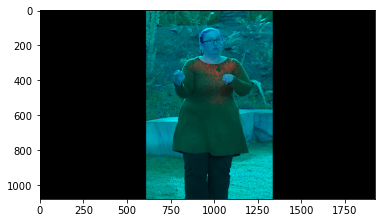

In [33]:
background_image = cv2.imread(background_image_loc)
heatmap_img = create_heatmap(points_dict, background_image, len(left_hand), radius)
print("Finished..")
plt.imshow(heatmap_img)
plt.plot()

In [17]:
left_hand

[(1053, 435),
 (1059, 434),
 (1062, 435),
 (1064, 439),
 (1065, 445),
 (1064, 449),
 (1064, 448),
 (1064, 446),
 (1054, 445),
 (1054, 430),
 (1054, 409),
 (1063, 381),
 (1063, 370),
 (1064, 361),
 (1071, 352),
 (1070, 356),
 (1039, 364),
 (1000, 402),
 (1003, 415),
 (996, 435),
 (994, 437),
 (981, 444),
 (977, 449),
 (972, 455),
 (978, 454),
 (979, 453),
 (981, 452),
 (983, 459),
 (979, 469),
 (979, 470),
 (980, 470),
 (986, 469),
 (989, 468),
 (989, 455),
 (1002, 405),
 (1064, 352),
 (1083, 340),
 (1085, 334),
 (1089, 335),
 (1084, 338),
 (1074, 368),
 (1071, 382),
 (1072, 395),
 (1070, 404),
 (1061, 408),
 (1051, 415),
 (1047, 419),
 (1048, 420),
 (1053, 415),
 (1067, 388),
 (1072, 375),
 (1069, 418),
 (1043, 450),
 (1043, 439),
 (1038, 415),
 (1032, 392),
 (1030, 380),
 (1023, 371),
 (1007, 376),
 (968, 375),
 (953, 378),
 (969, 393),
 (977, 404),
 (1003, 404),
 (1075, 348),
 (1093, 378),
 (1093, 379),
 (1076, 435),
 (1069, 460),
 (1056, 465),
 (1033, 496),
 (1022, 509),
 (1013, 515

In [193]:
def create_heatmap(all_points, background_image, total_points, sqr_len):
    max_prob = 0.0031565013746054373#0#0.03701252418287344
    total_prob = 0
    x_start, y_start = 0, 0
    total_points = len(all_points)
    height, width, _ = background_image.shape
    for y_end in range(sqr_len, height, sqr_len):
        for x_end in range(sqr_len, width, sqr_len):
            color = background_image[y_start:y_end, x_start:x_end]
            num_in_sqr = 0
            for point in all_points:
                #print(point[0], point[1], x_start, y_start, x_end, y_end)
                if (point[0] >= x_start) and (point[0] <= x_end) and (point[1] >= y_start) and (point[1] <= y_end):
                    num_in_sqr += 1
            prob = (num_in_sqr / total_points)/max_prob
            #print(num_in_sqr, total_points)
            #if prob > max_prob:
            #    max_prob = prob
            #if prob > 0:
                #print(num_in_sqr, total_points, prob)
            #print(color.shape)
            total_prob += prob
            if prob <= 0:
                background_image[y_start:y_end, x_start:x_end] = color
            else:
                
                color[:, :, 0] = 255*prob
                #color[:, :, 2] = 255*prob
                #color[:, :, 1] = 255*prob
                background_image[y_start:y_end, x_start:x_end] = color
            x_start = x_end
        y_start = y_end
    print(max_prob)
    print(total_prob)
    return background_image

0.0031565013746054373
455.04838709677585
Finished..


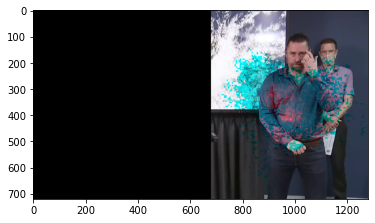

In [194]:
"""height, width = 1920, 1080
background_image = np.zeros((height,width, 3))"""

from_csv = "test.csv"
background_image_loc = "./img.png"

data = pd.read_csv(from_csv)
background_image = cv2.imread(background_image_loc)
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
height, width, _ = background_image.shape
all_points = []

data = pd.read_csv(from_csv)
left_hand = convert_csv_to_list_of_tuple(data["Left Hand.x"][0:num_points],
                                         data["Left Hand.y"][0:num_points], height, width)
right_hand = convert_csv_to_list_of_tuple(data["Right Hand.x"][0:num_points],
                                         data["Right Hand.y"][0:num_points], height, width)
all_points += left_hand + right_hand


heatmap_img = create_heatmap(all_points, background_image, len(all_points), 5)
print("Finished..")
cv2.imwrite("./heatmap.png", cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
plt.imshow(heatmap_img)
plt.show()
#plt.plot(all_points)
#plt.show()

In [117]:
print(len(all_points))

19998


In [ ]:
background_image = cv2.cvtColor(cv2.imread(background_image_loc), cv2.COLOR_BGR2RGB)

height, width, _ = background_image.shape
all_points = []
xs = []
ys = []
print(os.getcwd())
for file in os.listdir(os.getcwd()):
    if file.endswith(".csv"):
        data = pd.read_csv(file)
        xs.append(data["Left Hand.x"])
        ys.append(data["Left Hand.y"])
        xs.append(data["Right Hand.x"])
        ys.append(data["Right Hand.y"])


#heatmap_img = create_heatmap(all_points, background_image, len(all_points), 50)
#print("Finished..")
#cv2.imwrite("./heatmap.png", cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
#plt.imshow(background_image)
#plt.plot()
all_pointsx = pd.concat(xs)
all_pointsy = pd.concat(ys)        
plt.plot(all_pointsx, all_pointsy, 'o')
plt.show()